In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf  # optional, for candlesticks
plt.style.use("seaborn-v0_8")


In [18]:
# loading both data sets I scrape 
lmnd = pd.read_csv("Data/lmnd_daily_5y.csv", parse_dates=["Date"],)
allstate = pd.read_csv("Data/allstate_daily_5y.csv", parse_dates=["Date"],)


lmnd = lmnd.sort_values("Date").set_index("Date")
allstate = allstate.sort_values("Date").set_index("Date")


In [19]:
# look at the first few rows of both dataframes to ensure they loaded correctly
print("Lemonade Inc (LMND) Data:")
print(lmnd.head())
print("\nAllstate Corp (ALL) Data:")
print(allstate.head())

Lemonade Inc (LMND) Data:
            Adj Close      Close       High        Low       Open   Volume
Date                                                                      
2020-12-02  66.830002  66.830002  67.110001  62.310001  65.389999  1059000
2020-12-03  80.349998  80.349998  83.169998  65.919998  66.989998  9344400
2020-12-04  85.040001  85.040001  85.949997  78.029999  82.500000  5463900
2020-12-07  91.720001  91.720001  99.989998  88.019997  90.029999  7528100
2020-12-08  90.599998  90.599998  97.650002  89.349998  97.309998  3844500

Allstate Corp (ALL) Data:
            Adj Close       Close        High         Low        Open   Volume
Date                                                                          
2020-12-02  92.113419  103.680000  105.239998  102.959999  104.059998  1710400
2020-12-03  92.246674  103.830002  104.300003  102.699997  103.089996  1435600
2020-12-04  92.717552  104.360001  104.879997  103.720001  104.199997  1243800
2020-12-07  91.873528  103.

In [20]:
# Restrict to overlapping date range and rename columns to avoid clashes when merging
start = max(lmnd.index.min(), allstate.index.min(), )
end = min(lmnd.index.max(), allstate.index.max(), )

lmnd = lmnd.loc[start:end]
allstate = allstate.loc[start:end]

lmnd = lmnd.add_prefix("LMND_")
allstate = allstate.add_prefix("ALL_")


In [21]:
# combining both dataframes into one for comparison using inner join on date index
combined = lmnd.join(allstate, how="inner")
print("\nCombined Data:")
print(combined.head())




Combined Data:
            LMND_Adj Close  LMND_Close  LMND_High   LMND_Low  LMND_Open  \
Date                                                                      
2020-12-02       66.830002   66.830002  67.110001  62.310001  65.389999   
2020-12-03       80.349998   80.349998  83.169998  65.919998  66.989998   
2020-12-04       85.040001   85.040001  85.949997  78.029999  82.500000   
2020-12-07       91.720001   91.720001  99.989998  88.019997  90.029999   
2020-12-08       90.599998   90.599998  97.650002  89.349998  97.309998   

            LMND_Volume  ALL_Adj Close   ALL_Close    ALL_High     ALL_Low  \
Date                                                                         
2020-12-02      1059000      92.113419  103.680000  105.239998  102.959999   
2020-12-03      9344400      92.246674  103.830002  104.300003  102.699997   
2020-12-04      5463900      92.717552  104.360001  104.879997  103.720001   
2020-12-07      7528100      91.873528  103.410004  104.400002  102.

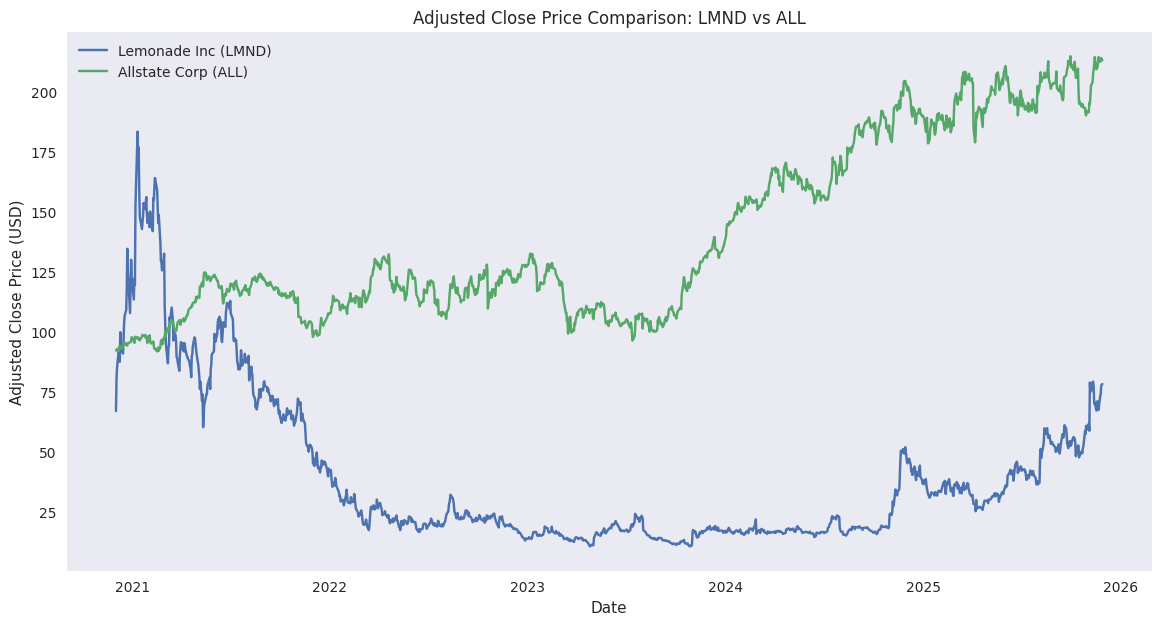

In [22]:
# compare adjusted close prices over time
plt.figure(figsize=(14, 7))
plt.plot(combined.index, combined["LMND_Adj Close"], label="Lemonade Inc (LMND)",)
plt.plot(combined.index, combined["ALL_Adj Close"], label="Allstate Corp (ALL)", )
plt.title("Adjusted Close Price Comparison: LMND vs ALL")
plt.xlabel("Date")
plt.ylabel("Adjusted Close Price (USD)")
plt.legend()
plt.grid()
plt.show()

In [23]:
# adding a new column that shows daily returns for both stocks
combined["LMND_ret"] = combined["LMND_Adj Close"].pct_change()
combined["ALL_ret"] = combined["ALL_Adj Close"].pct_change()


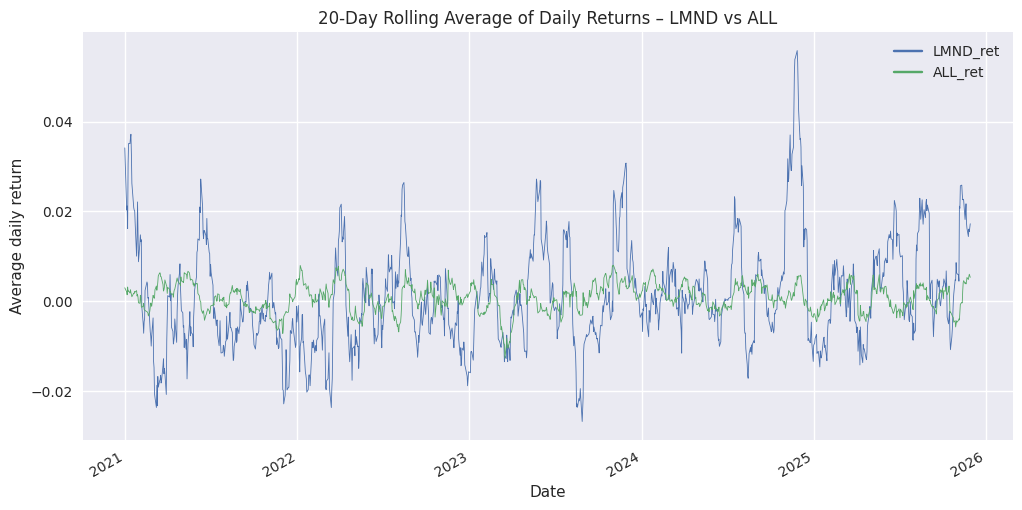

In [27]:
combined.head()

window = 20  # about a month

roll = combined[["LMND_ret", "ALL_ret"]].rolling(window).mean()

ax = roll.plot(figsize=(12, 6))
# set line widths for better visibility
for line in ax.get_lines():
    line.set_linewidth(0.6)
ax.set_title(f"{window}-Day Rolling Average of Daily Returns – LMND vs ALL")
ax.set_ylabel("Average daily return")
plt.show()


We are also interested in seeing what days lemonade inc had significant volume spikes as we want to figure out what was happening on those days 
that caused such a spike in volume.

In [13]:
threshold = combined["LMND_Volume"].quantile(0.95)
high_vol_days = combined[combined["LMND_Volume"] >= threshold]
print(len(high_vol_days), "high-volume days")


63 high-volume days


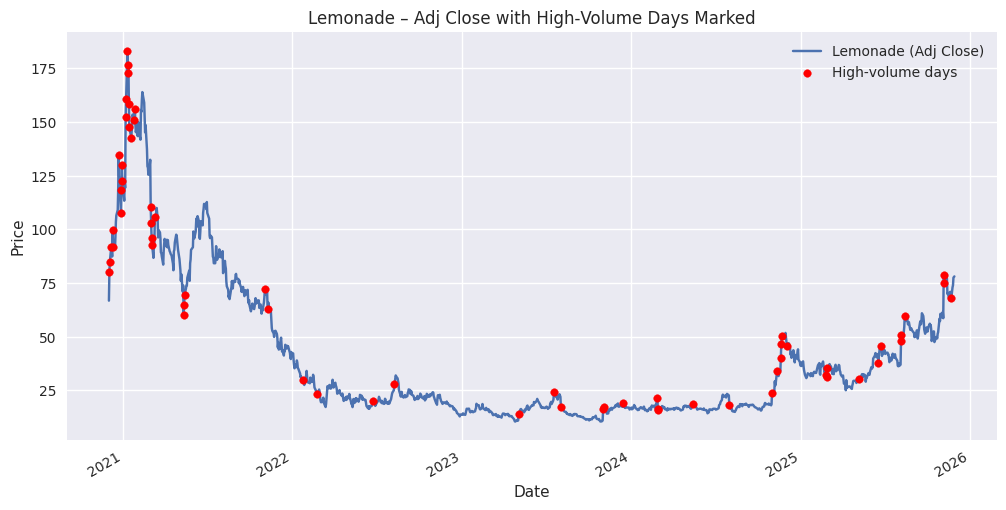

High Volume Days:
            LMND_Adj Close  LMND_Volume
Date                                   
2020-12-03       80.349998      9344400
2020-12-04       85.040001      5463900
2020-12-07       91.720001      7528100
2020-12-10       99.699997      7697800
2020-12-11       91.589996      5590400
...                    ...          ...
2025-08-06       51.070000      5643000
2025-08-13       59.700001      6440700
2025-11-05       78.730003     13344400
2025-11-06       75.129997      5428500
2025-11-20       67.970001      4598900

[63 rows x 2 columns]


In [14]:
fig, ax = plt.subplots(figsize=(12, 6))
combined["LMND_Adj Close"].plot(ax=ax, label="Lemonade (Adj Close)")

ax.scatter(
    high_vol_days.index,
    high_vol_days["LMND_Adj Close"],
    color="red",
    label="High‑volume days",
    zorder=3,
    s=30,
)

ax.set_title("Lemonade – Adj Close with High‑Volume Days Marked")
ax.set_ylabel("Price")
ax.legend()
plt.show()
# saving the high volume days to a csv for further analysis by Chris Keating
print("High Volume Days:")
print(high_vol_days[["LMND_Adj Close", "LMND_Volume"]]) 
# high_vol_days[["LMND_Adj Close", "LMND_Volume"]].to_csv("Data/lmnd_high_volume_days.csv")


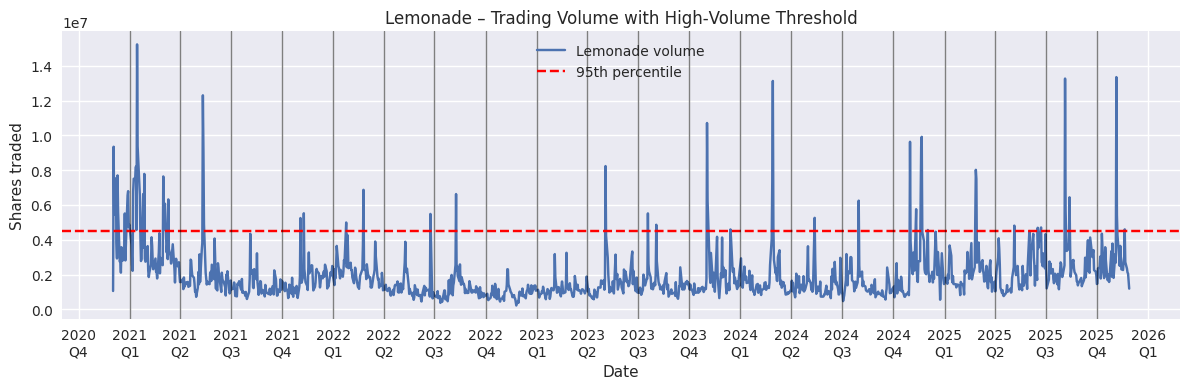

In [16]:
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter


# quarterly markers instead of yearly markers 
fig, ax = plt.subplots(figsize=(12, 4))
combined["LMND_Volume"].plot(ax=ax, label="Lemonade volume")
ax.axhline(threshold, color="red", linestyle="--", label="95th percentile")
ax.set_title("Lemonade – Trading Volume with High‑Volume Threshold")
ax.set_ylabel("Shares traded")

# Set quarterly markers (Jan, Apr, Jul, Oct)
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 4, 7, 10]))

# Custom formatter to show quarters
def quarter_formatter(x, pos):
    date = mdates.num2date(x)
    month = date.month
    year = date.year
    quarter = {1: 'Q1', 4: 'Q2', 7: 'Q3', 10: 'Q4'}.get(month, '')
    return f'{year}\n{quarter}'

ax.xaxis.set_major_formatter(FuncFormatter(quarter_formatter))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=0, ha='center')

# Add vertical lines at quarter boundaries
start_year = combined.index.min().year
end_year = combined.index.max().year
for year in range(start_year, end_year + 1):
    for month in [1, 4, 7, 10]:
        quarter_start = pd.Timestamp(year=year, month=month, day=1)
        if combined.index.min() <= quarter_start <= combined.index.max():
            ax.axvline(quarter_start, color='black', linestyle='-', alpha=0.5, linewidth=1)

ax.legend()
plt.tight_layout()
plt.show()